In [1]:
%load_ext autoreload
%autoreload 2


In [25]:
#load modules
import datacube
dc = datacube.Datacube()
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube import helpers
import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from scipy import ndimage

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats

from ipywidgets import interact, fixed
import ipywidgets as widgets


# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [26]:

query = {
      'lat': (-33.107410, -33.216838),
      'lon': (148.264306, 148.470191),

        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-01-01', '2016-12-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_fc = dc.load(product='ls8_fc_albers', group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)


In [27]:
one_fc = data_fc.isel(time=3)
one_fc

<xarray.Dataset>
Dimensions:  (x: 2049, y: 1457)
Coordinates:
    time     datetime64[ns] 2016-02-29T23:55:58
  * y        (y) float64 -3.707e+06 -3.707e+06 -3.707e+06 -3.707e+06 ...
  * x        (x) float64 1.502e+06 1.502e+06 1.502e+06 1.502e+06 1.502e+06 ...
Data variables:
    BS       (y, x) int8 15 15 24 24 23 23 23 20 20 20 20 20 22 22 17 17 17 ...
    PV       (y, x) int8 24 24 26 26 22 22 22 19 19 20 20 20 22 22 32 32 32 ...
    NPV      (y, x) int8 60 60 48 48 54 54 54 60 60 59 59 59 55 55 50 50 50 ...
    UE       (y, x) int8 9 9 8 8 8 8 8 8 8 8 8 8 8 8 10 10 10 9 9 8 8 8 9 9 ...
Attributes:
    crs:      EPSG:3577

HTML(value='Click on the pixel you would like to interrogate')

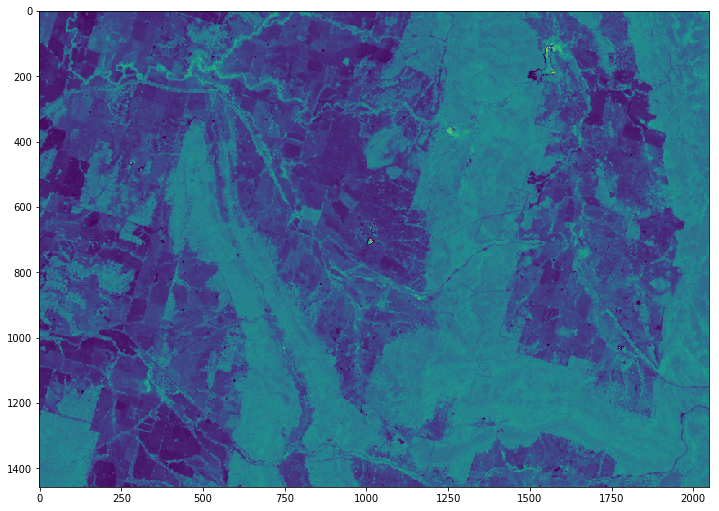

In [37]:
#print('\033[1m' + 'Click on the pixel you would like to interrogate' + '\033[0m')

#DEAPlotting.three_band_image(data, bands=['swir1', 'nir', 'green'], time=1)

fig, ax = plt.subplots(figsize = (12,12))
plt.imshow(one_fc.PV)
w = widgets.HTML("Click on the pixel you would like to interrogate")


def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = data.affine * (x, y)
    pixelx = int(image_coords[0])
    pixely = int(image_coords[1])
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

In [38]:
fig = plt.figure(figsize=[10, 10])

plt.plot(data_fc.time, data_fc.BS.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-')
plt.xlabel('Date', fontsize=16)
plt.ylabel('NBART Reflectance (x 10000)', fontsize=16)
plt.title(
    'Select a data point to plot up the accompanying satellite image', fontsize=20)


NameError: name 'pixely' is not defined

<Figure size 720x720 with 0 Axes>

In [20]:
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
helpers.write_geotiff('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/FC_parks_2016.tif',one_fc)

In [3]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band=1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [4]:
#define area
# open  shapfile and data loat from that
def make_coords(filename):
    shapefile_loc='/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_for_train/'+filename

    #import project area shapefiles
    project_area = gpd.read_file(shapefile_loc)

    #convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
    project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

    #find the bounding box that contains all the queried projects

    coords = project_area.total_bounds
    xmin, ymax, xmax, ymin =coords
    return(xmin, ymax, xmax, ymin)

def load_data(xmin, ymax, xmax, ymin):#load sentinal data
    sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

    bands_of_int =['red'
             #'blue', 'green', 'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 'pixel_quality'
                  ] #pick the sentinal bands that you want, here i am just using visible light  

    query = {
            'lat': (ymin, ymax),
            'lon': (xmin, xmax),
            'output_crs': 'EPSG:3577',
            'resolution': (-10, 10),
            'time':('2016-01-01', '2016-03-30')
            }
      
# use s2b_ard_granule 	 for S2B
    data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
    data_sent= data_sent.isel(time=0)
    return(data_sent)
#data_sent = data_sent.where(clear_pixels)


In [5]:
#turn array into panda series
def array_topanda_s(array):
    a,b = array.shape
    length_be = int(a)+int(b)
    try:
        flat = array.stack(z=('y','x'))
    except:
        flat = array.stack(z=('latitude', 'longitude'))
    #ones_array = np.ones_like(flat)
    #ones_array = np.where(flat)
    panda_series = pd.Series(flat)
    return(panda_series)

In [6]:
parks = '/g/data/u46/users/dxr251/woody-v6/woody_60_-149.tif'
canberra_east = '/g/data/u46/users/dxr251/woody-v6/woody_62_-159.tif'


In [14]:
#filelist = ['ncas_base_1.shp','ncas_base_2.shp','ncas_base_3.shp','ncas_base_4.shp']
#filelist = ['ncas_base_6.shp','ncas_base_7.shp','ncas_base_8.shp']
filelist = [('ncas_base_1.shp',parks),('ncas_base_2.shp',parks),('ncas_base_3.shp',parks),('ncas_base_4.shp',parks),
            ('ncas_base_5.shp',parks),('ncas_base_6.shp',canberra_east),('ncas_base_7.shp',canberra_east),
            ('ncas_base_8.shp',canberra_east)]


master_panda = pd.DataFrame()

In [8]:
def create_slope(dem_data):
    """this is a rough and ready way to get a slope map out of a DEM, it is based on Numpy modules 
    and the definition slope = tan-1(rize/run). the product is a map of 'maximum slope' along either axis of the array
    
    input= DEM. digital elevation model DataSet from dc.load(product='dsm1sv10')
    Output= DEM DataSet with Slope added as a variable """
    
    elevation = dem_data.elevation[0,:,:]# get the 2D DataArray from the dataset

    #convert the elevation data to gradient using g=rize over run
    datagrad2,datagrad3 = np.gradient(elevation, axis=(0,1))

    #convert to degrees slope using slope = tan-1(gradient).
 
    dataslope_ns = np.rad2deg(np.arctan(datagrad2))
    dataslope_ew = np.rad2deg(np.arctan(datagrad3))

    #turn angle of slope into absolute values as we don't acually want negative slope
    dataslope_ns_abs = np.absolute(dataslope_ns)
    dataslope_ew_abs = np.absolute(dataslope_ew)

    #combine N-S and E-W slopemaps into a sigle map, with largest values for each square
    dataslope_all = np.maximum(dataslope_ns_abs, dataslope_ew_abs)
    
    gsm_dataslope_all = ndimage.gaussian_filter(dataslope_all, sigma=1.5)
    
    gsm_dataslope_all = xr.DataArray(gsm_dataslope_all,dims=('latitude', 'longitude'))
    
    dem_data['slope'] = gsm_dataslope_all
    return(dem_data)

I am densified (external_values, 1 elements)


(127, 160)

<xarray.DataArray 'elevation' (latitude: 127, longitude: 160)>
array([[-21.744446, -24.083557, -25.988037, ...,  -0.169556,   0.866577,
          2.742615],
       [-20.605408, -23.037598, -25.105957, ...,   2.488892,   3.007202,
          3.704895],
       [-20.095276, -22.75232 , -25.077515, ...,   4.298279,   3.956299,
          3.799988],
       ...,
       [-42.864532, -42.850098, -42.48587 , ...,  -7.844666,  -8.819824,
        -10.292664],
       [-44.645355, -44.61737 , -43.88153 , ..., -12.422668, -13.245056,
        -14.235535],
       [-46.164062, -46.40387 , -45.52188 , ..., -16.24408 , -16.120544,
        -16.140625]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2000-02-17T08:33:00
  * latitude   (latitude) float64 -33.18 -33.18 -33.18 -33.18 -33.18 -33.18 ...
  * longitude  (longitude) float64 148.4 148.4 148.4 148.4 148.4 148.4 148.4 ...

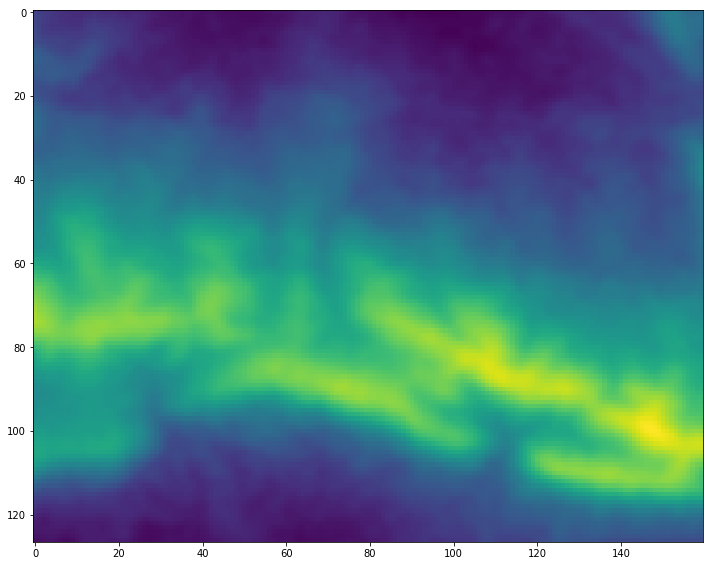

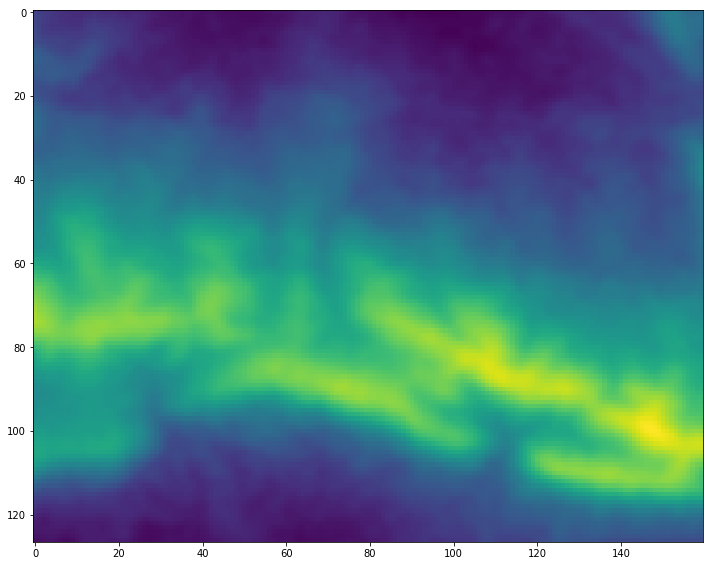

In [16]:


for file_x,file_y in filelist:
    #create panda_dataframe
    #open some sent data
    xmin, ymax, xmax, ymin = make_coords(file_x)
    query = {}
    query['x'] = (xmin,xmax)
    query['y'] = (ymin,ymax)

    dsm = dc.load(product='dsm1sv10',**query)
    elevation = dsm.elevation[0,:,:]
    #slope = create_slope(dsm) #define the Geobox
    
    #figureout std of elevation
    elevation_std = np.std(elevation,axis=(0,1))
    #elevation_series = array_topanda_s(elevation_std)

    geobox =dsm.geobox
    
    #use sent geobox to load up ncas product and smad_green prod.
    ncas = rasterfile_to_xarray("/g/data/u46/users/fxy120/australian_woody/mosaics/lztmre_aus_y20002011_dm7a2_d20050630.tif",
                                geobox, X_band=(1) )
    
    ncas_class = np.logical_and(ncas>110, ncas<200)
    #ncas_class = np.ones_like(ncas_class)
    #change shape to 1D add to dataframe
    ncass_series = array_topanda_s(ncas_class)
    little_panda = pd.DataFrame(ncass_series, columns=['class'])
    little_panda = little_panda.replace(to_replace=[False,True], value=[0,1])
    
    #little_panda['elevation'] = elevation_series
    #load smad_green product
    
    group_smad_green = {}
    bands=[1,2,3]
    
    for band in bands:
        smad_green = rasterfile_to_xarray(file_y,
                                   geobox, num_bands=(1,2,3), X_band=band)
        smad_green_series = array_topanda_s(smad_green)
    
        little_panda[band] = smad_green_series
    

    #create slope    
    #add slope as a variable
#     fig, ax = plt.subplots(figsize = (12,12))
#     cax = ax.imshow(elevation)

#     plt.show()
    
    elevation_std
    master_panda = master_panda.append(little_panda,ignore_index=True)
master_panda

I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


I am densified (external_values, 1 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


,class,1,2,3
0,0,0.011901,0.478185,0.448217
1,0,0.007710,0.443336,0.430334
2,0,0.006552,0.452418,0.443837
3,0,0.006581,0.444237,0.442053
4,0,0.006155,0.424542,0.444962
5,0,0.006485,0.437431,0.445485
6,0,0.004184,0.419859,0.421206
7,0,0.001740,0.341268,0.346248
8,0,0.002779,0.343427,0.338281
9,0,0.002023,0.325734,0.328925


In [10]:
master_panda.to_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/training_datasets/ncas_truthed_landsat_welevation.csv')

In [11]:
new_panda.to_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/training_datasets/ncas_truthed_landsat_wslope_3.csv')

NameError: name 'new_panda' is not defined